In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#get data and train-test split 80-20

start = '2003-01-01'
end = '2018-01-01'

data = get_pricing('spy', start_date = start, end_date = end , fields = 'price').pct_change()[1:]

train_pct = 0.1
train = data.iloc[:-int(train_pct*len(data))]
test = data.iloc[-int(train_pct*len(data)):]


In [3]:
#check that train and test dont overlap
print(train.tail())
print(test.head())


2016-06-27 00:00:00+00:00   -0.017861
2016-06-28 00:00:00+00:00    0.017990
2016-06-29 00:00:00+00:00    0.017124
2016-06-30 00:00:00+00:00    0.013694
2016-07-01 00:00:00+00:00    0.001574
Freq: C, Name: Equity(8554 [SPY]), dtype: float64
2016-07-05 00:00:00+00:00   -0.006670
2016-07-06 00:00:00+00:00    0.006334
2016-07-07 00:00:00+00:00   -0.001101
2016-07-08 00:00:00+00:00    0.014939
2016-07-11 00:00:00+00:00    0.003528
Freq: C, Name: Equity(8554 [SPY]), dtype: float64


0.111111111111


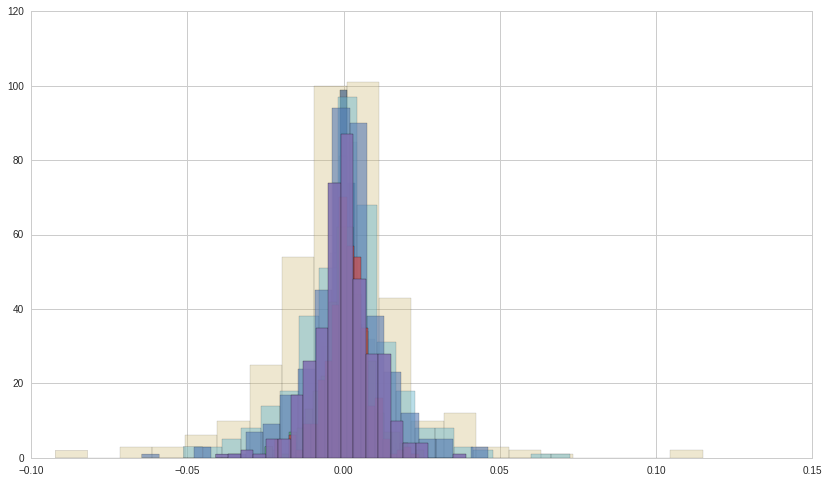

In [4]:

plt.hist(test, bins = 20)
#plot histogram for various subsets of train of the same size as test to compare distributions
for i in range(int(len(train)/len(test))):
    alpha_tune = float(1)/int(len(train)/len(test))
    plt.hist(train[i* len(test):(i+1)*len(test)], bins = 20, alpha = i* alpha_tune)


print(alpha_tune)

It seems that they do not have identical distributions afterall. Check if code is running as expected, are there larger sample sizes in play?,save eatch of their distributions datao n a table e.g pandas and then plot

In [5]:
subset_stats = pd.DataFrame()

for i in range(int(len(train)/len(test))):
    subset_stats[i] = train[i* len(test):(i+1)*len(test)].describe()


In [6]:
subset_stats

,0,1,2,3,4,5,6,7,8
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,0.000674,0.000378,0.000601,-0.001158,0.000689,0.000680,0.000742,0.000777,0.000070
std,0.009650,0.006553,0.006588,0.021535,0.015667,0.013072,0.007974,0.006784,0.009753
min,-0.035212,-0.016612,-0.035846,-0.092259,-0.051304,-0.064564,-0.025166,-0.022067,-0.040896
25%,-0.005275,-0.004011,-0.002775,-0.010748,-0.006110,-0.004785,-0.003347,-0.002824,-0.004698
50%,0.000951,0.000679,0.000850,0.000134,0.001219,0.000816,0.000630,0.000949,0.000000
75%,0.006081,0.004471,0.004059,0.007921,0.008348,0.006862,0.005424,0.004917,0.005344
max,0.034912,0.019338,0.021353,0.114971,0.072487,0.046226,0.025828,0.024015,0.039146


the above implies that they have eqal sample sizes

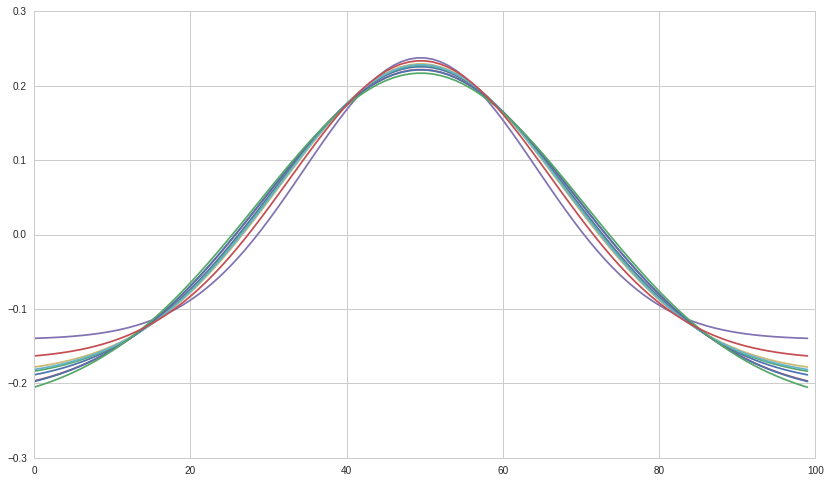

In [7]:


for i in xrange(subset_stats.shape[1]):
    subset = subset_stats[i]
    mu = subset['mean']
    stdev = subset['std']
    variance = stdev ** 2
    def normalise(subset):
        for i in range(len(subset)):
            subset[i] = (subset[i]-mu)/ stdev
        return subset
        
    subset = normalise(subset)
    mean = subset['mean']
    sigma = subset['std']
    variance = sigma ** 2
            
    x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
    f = np.exp(-np.square(x-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
    f = f -np.mean(f)
    #print(f)
    plt.plot(f)


showsthat they atuall do have similar distributions

In [8]:
subset_stats[1]['mean']

0.0

In [9]:
type(train)

<class 'pandas.core.series.Series'>

back to application of word context to returns

In [10]:
train = data.iloc[:-int(train_pct*len(data))]
train = pd.Series(list(train)+ list(test))
print(train.shape)

def discretise(train):
    
    mean = train.mean()
    std = train.std()
    disc_train = pd.DataFrame(np.zeros((train.shape)))

    for i in range(len(train)):
        disc_train[0][i] = np.ceil(train[i]/std)
    
    return disc_train




disc_train = discretise(train)

np.min(disc_train)
np.max(disc_train)

disc_train.shape

size_of_context = 21





def generate_context(train, size = 7):
    shaper = np.zeros((len(train), size))
    #print(shaper.shape)
    context = pd.DataFrame(shaper)
    #print(context.shape)
    #print(train.shape)
    for i in range(int(size/2),len(train)-int(size/2)):
        #print(i)
        context.iloc[i][0] = train.iloc[i][0]
        for j in range(np.int(size/2)):
            #print(j)
            context.iloc[i][j] = train.iloc[i+j][0]
        for j in range(1,np.int(size/2)):
            #print(j)
            context.iloc[i][j+np.int(size/2)+1]= train.iloc[i-j][0]
            
    return context

context = generate_context(disc_train, size_of_context)[int(size_of_context/2):]


(3775,)


In [11]:
context.shape

(3765, 21)

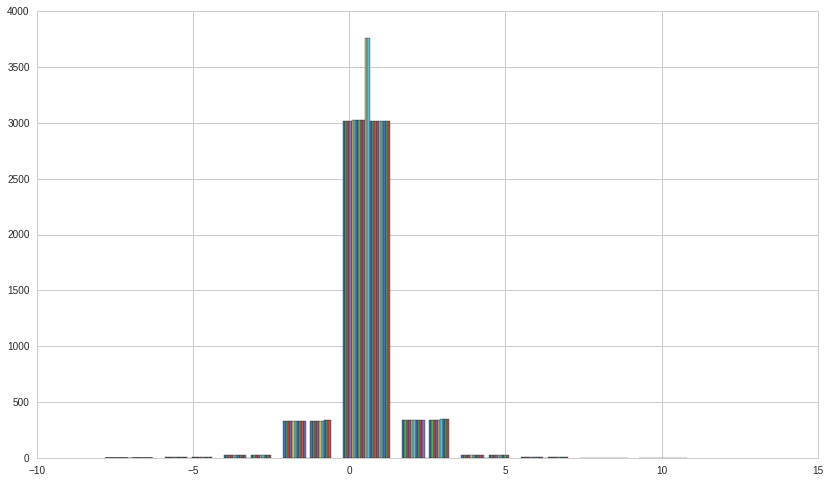

In [12]:
plt.hist(context);

#pd.DataFrame(np.array(context[context>0]).reshape(context.shape[0]*context.shape[1])).dropna().mean()


In [13]:
def retrieve_interest(context, min_sd= 2):#min_sd refers to the lower limit of day returns' context to retrieve
    interest = pd.DataFrame(np.ones(context.shape)*1000)
    for i in range(len(context)):
        if min_sd > 0:
            if context.iloc[i][0]>= min_sd:
                interest.iloc[i] = context.iloc[i]
                #print context.iloc[i][0]
        elif min_sd < 0:
            if context.iloc[i][0]<= min_sd:
                interest.iloc[i] = context.iloc[i]
                
            
    return interest



    
interest = retrieve_interest(context,1)
interest = interest[interest != 1000]
interest

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,-2.0,-1.0,2.0,1.0,-2.0,2.0,1.0,-1.0,-0.0,...,0.0,-0.0,-1.0,-1.0,-0.0,-1.0,1.0,-0.0,-0.0,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,1.0,-2.0,2.0,1.0,-1.0,-0.0,-0.0,-0.0,1.0,...,0.0,-1.0,-2.0,2.0,-0.0,-1.0,-1.0,-0.0,-1.0,1.0
7,1.0,-2.0,2.0,1.0,-1.0,-0.0,-0.0,-0.0,1.0,-0.0,...,0.0,2.0,-1.0,-2.0,2.0,-0.0,-1.0,-1.0,-0.0,-1.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,1.0,-1.0,-0.0,-0.0,-0.0,1.0,-0.0,-1.0,-0.0,...,0.0,-2.0,1.0,2.0,-1.0,-2.0,2.0,-0.0,-1.0,-1.0


In [14]:
from collections import Counter

interest = (interest[interest !=0]*100)

mean = np.zeros(interest.shape[1])
median = np.zeros(interest.shape[1])
mode = np.zeros(interest.shape[1])
for i in range(interest.shape[1]):
    #print i
    mean[i] = np.mean(pd.DataFrame(np.array(interest.iloc[:][i]).reshape(len(interest))).dropna())
    median[i] = np.median(pd.DataFrame(np.array(interest.iloc[:][i]).reshape(len(interest))).dropna())
    data = Counter(interest.iloc[:][i])
    counts = data.most_common
    mode[i] = data.most_common(1)[0][0]
    




/venvs/py27/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.   nan   nan
  100.  100.  100.  100.  100.  100.  100.  100.  100.]
[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.   nan   nan
  100.  100.  100.  100.  100.  100.  100.  100.  100.]


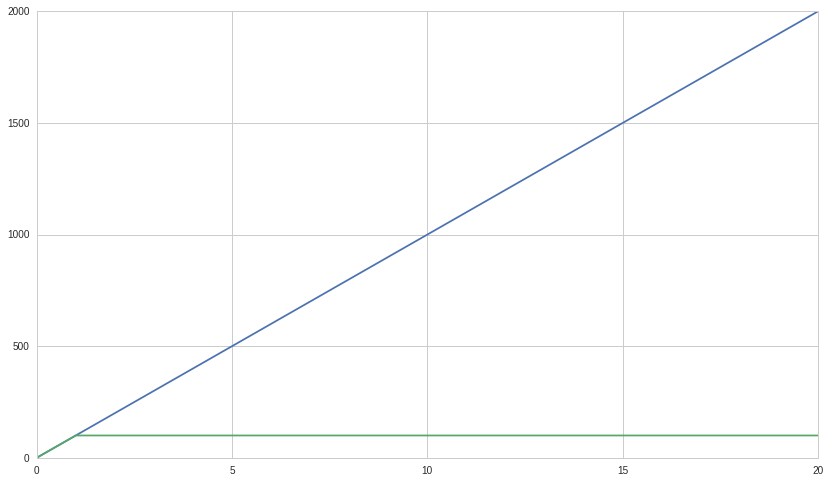

In [15]:
#print(mean)
#mean = mean[mean!=0]
#plt.stem(range(0,len(mean)),np.cumsum(mean))
#plt.plot(np.cumsum(pd.DataFrame(mean).pct_change()))
#plt.plot(mean[1:])
#mean is less informative as it eradicates tthe effect of -ve values 
print(median)
median[10:12] = median[0]
median[0] = 0
plt.plot(np.cumsum(median))
print(mode)
mode[10:12] = mode[0]
mode[0] = 0
plt.plot(mode)


In [16]:
mean

array([ 125.2559727 ,   79.90468626,   84.48947779,   85.33026114,
         84.75750577,   81.94973343,   83.66412214,   83.95638629,
         84.60365854,   82.56528418,           nan,           nan,
         77.26920093,   84.09785933,   87.27134146,   84.24657534,
         82.1347464 ,   85.76835731,   79.95391705,   84.1472577 ,
         80.10590015])

In [17]:
import seaborn as sb


#leave interets for now. Perform decision trees on context using context day returns as features and returns

In [18]:
from sklearn.tree import DecisionTreeClassifier


def rediscretise(y):
    #y = [1 if yy >0 else 0 for yy in y]
    yy = []#np.array(len(y))
    for i in y:#range(len(y)):
        if i > 0:
            i = 1
        elif i == 0:
            i = 0
        elif i < 0:
            i = -1
        yy.append(i)
    yy = np.array(yy)
    return yy

wait_days  = 3 #defines number of days to hold
n_samp = np.int(context.shape[0]/1.7)
n_feat = np.int(context.shape[1]/2)+1
print(n_feat)
sub_context1 = context.iloc[:n_samp][:]#top part
#print(sub_context1.shape)
X1 = sub_context1.iloc[:,:n_feat]#left features
print(X1.shape)
y1_raw = sub_context1.iloc[:,n_feat+1:n_feat+1  + wait_days]#right features
#print(y1.shape)
y1 = np.sum(y1_raw, axis = 1)
y1_analysis = y1
print(len(y1[y1>0]),'!')
y1 = np.array(y1)
#y1 = rediscretise(y1)




sub_context2 = context.iloc[:context.shape[0]][:]
#print(sub_context1.shape)
X2 = sub_context2.iloc[:,:n_feat]#left features
print(X2.shape)
y2_raw = sub_context2.iloc[:,n_feat:n_feat + wait_days]#right features
#print(y2.shape)
y2 = np.sum(y2_raw, axis = 1)
#print(y2)
y2 = np.array(y2)
#y2 = rediscretise(y2)






11
(2214, 11)
(1734, '!')
(3765, 11)


In [19]:
for i in range(len(y1)):
    r[i] = y1[i]* np.sum(data[i+n_feat+1:i+n_feat +1 + wait_days])
#plt.plot(np.cumsum(r))
print y1
plt.plot(np.cumsum(r))
plt.figure()
plt.plot(np.cumsum(data))

TypeError: unhashable type

0.10298102981029811

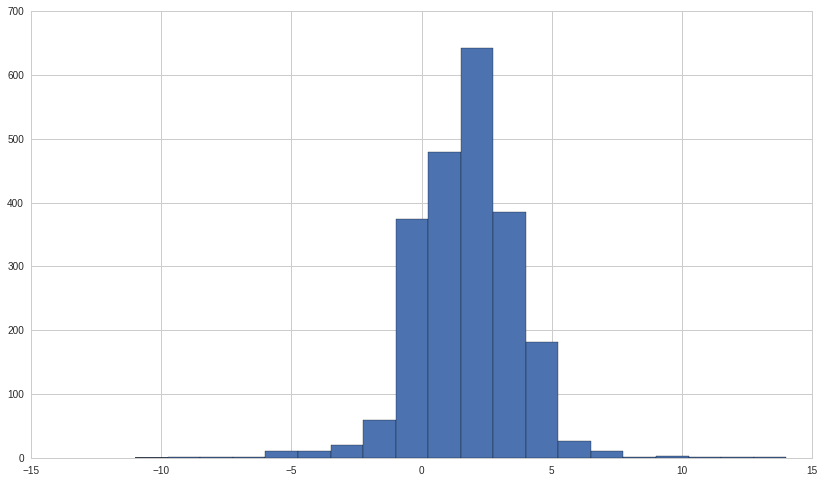

In [20]:
plt.hist(y1_analysis, bins = 20);
float(len(y1_analysis[y1_analysis < 0]))/ len(y1_analysis)

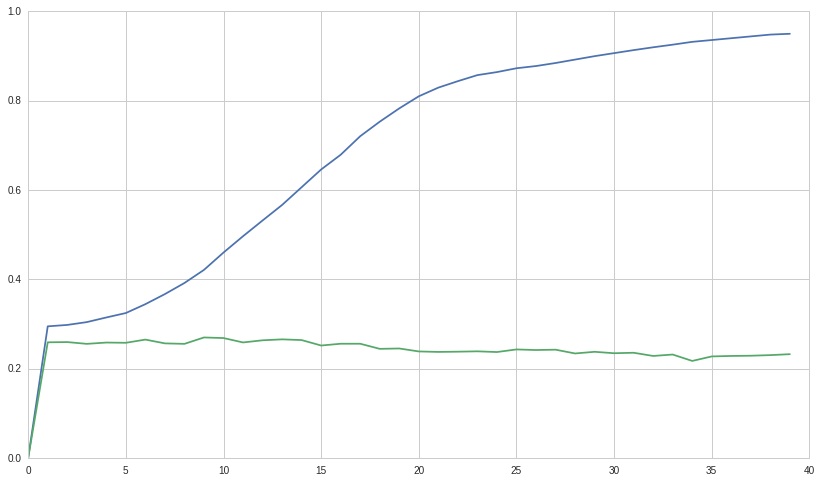

In [21]:
from sklearn.decomposition import PCA

max_depth = 40 #max depth of tree
errnp = np.zeros((max_depth,2))
errors = pd.DataFrame(errnp)
hit_rates = pd.DataFrame(errnp, columns = ['train', 'test'])
#print(errors)
for i in xrange(1,max_depth):
    pca_model = PCA(n_components = 5)
    pca_X1 = pca_model.fit(X1).transform(X1)
    pca_X2 = pca_model.fit(X2).transform(X2)

    model = DecisionTreeClassifier(max_depth = i)
    model = model.fit(pca_X1,y1)
    y1_hat = model.predict(pca_X1)
    y2_hat = model.predict(pca_X2)
    RMSE_1 = np.sqrt(sum((y1 - y1_hat)**2))/len(y1)
    RMSE_2 = np.sqrt(sum((y2 - y2_hat)**2))/len(y2)
    hit_rate1 = float((np.sum(y1 == y1_hat)))/ len(y1)
    hit_rate2 = float((np.sum(y2 == y2_hat)))/ len(y2)
    #print(hit_rate1, hit_rate2)
    #print(RMSE_1, RMSE_2)
    errors.iloc[i][0] = RMSE_1
    errors.iloc[i][1] = RMSE_2
    hit_rates.iloc[i][0] = hit_rate1
    hit_rates.iloc[i][1] = hit_rate2
    #print(i)
hit_rates.head(5)
hit_rates.tail(5)
#print(hit_rates.loc[:]['train'])
#plt.plot(hit_rates.iloc[:]['train'], hit_rates.iloc[:]['test'])
plt.figure()
plt.plot(hit_rates)
#plt.legend(hit_rates.columns)


In [22]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model = LR_model.fit(X1,y1)
y1_hat = LR_model.predict(X1)
y2_hat = LR_model.predict(X2)

RMSE_1 = np.sqrt(sum((y1 - y1_hat)**2))/len(y1)
RMSE_2 = np.sqrt(sum((y2 - y2_hat)**2))/len(y2)
hit_rate1 = float((np.sum(y1 == y1_hat)))/ len(y1)
hit_rate2 = float((np.sum(y2 == y2_hat)))/ len(y2)
#print(hit_rate1, hit_rate2)
#print(RMSE_1, RMSE_2)

print(hit_rate1, hit_rate2)
print(RMSE_1, RMSE_2)
print(X1.shape)

(0.2981029810298103, 0.2597609561752988)
(0.039437904160692094, 0.0271891067372865)
(2214, 11)


In [23]:
DT_model = DecisionTreeClassifier(max_depth = 10)
DT_model = DT_model.fit(X1,y1)
y1_hat = DT_model.predict(X1)
y2_hat = DT_model.predict(X2)

RMSE_1 = np.sqrt(sum((y1 - y1_hat)**2))/len(y1)
RMSE_2 = np.sqrt(sum((y2 - y2_hat)**2))/len(y2)
hit_rate1 = float((np.sum(y1 == y1_hat)))/ len(y1)
hit_rate2 = float((np.sum(y2 == y2_hat)))/ len(y2)
#print(hit_rate1, hit_rate2)
#print(RMSE_1, RMSE_2)

print(hit_rate1, hit_rate2)
print(RMSE_1, RMSE_2)

(0.453929539295393, 0.2743691899070385)
(0.033502921247791681, 0.026638662989084957)


In [24]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 5)
pca_X1 = pca_model.fit(X1).transform(X1)
pca_X2 = pca_model.fit(X2).transform(X2)

model = DecisionTreeClassifier(max_depth = 3)
model = model.fit(pca_X1,y1)
pca_y1_hat = model.predict(pca_X1)
pca_y2_hat = model.predict(pca_X2)

RMSE_1 = np.sqrt(sum((y1 - y1_hat)**2))/len(y1)
RMSE_2 = np.sqrt(sum((y2 - y2_hat)**2))/len(y2)
pca_hit_rate1 = float((np.sum(y1 == pca_y1_hat)))/ len(y1)
pca_hit_rate2 = float((np.sum(y2 == pca_y2_hat)))/ len(y2)

print(pca_hit_rate1, pca_hit_rate2)
print(RMSE_1, RMSE_2)




(0.3039747064137308, 0.2552456839309429)
(0.033502921247791681, 0.026638662989084957)


#TEST THE MODEL ON NEW DATA OF A DIFFERENT STOCK

In [25]:
start = '2003-01-01'
end = '2018-01-01'

data = get_pricing('msft', start_date = start, end_date = end, fields = 'price').pct_change()[1:]

In [26]:
disc_train = discretise(data)
context = generate_context(disc_train, size_of_context)[int(size_of_context/2):]

In [27]:
def rediscretise(y):
    #y = [1 if yy >0 else 0 for yy in y]
    yy = []#np.array(len(y))
    for i in y:#range(len(y)):
        if i > 0:
            i = 1
        elif i == 0:
            i = 0
        elif i < 0:
            i = -1
        yy.append(i)
    yy = np.array(yy)
    return yy

wait_days  = 3 #defines number of days to hold
n_samp = np.int(context.shape[0]/1.7)
n_feat = np.int(context.shape[1]/2)+1
print(n_feat)
sub_context1 = context
#print(sub_context1.shape)

X1 = sub_context1.iloc[:,:n_feat]#left features
print(X1.shape)
y1_raw = sub_context1.iloc[:,n_feat:n_feat+1 + wait_days+1]#right features
#print(y1.shape)
y1 = np.sum(y1_raw, axis = 1)
y1_analysis = y1
print(len(y1[y1>0]),'!')
y1 = np.array(y1)
#y1 = rediscretise(y1)


11
(3765, 11)
(3156, '!')


In [28]:



DT_model = DT_model.fit(X1,y1)
y1_hat = DT_model.predict(X1)


RMSE_1 = np.sqrt(float(sum((y1 - y1_hat)**2))/len(y1))

hit_rate1 = float((np.sum(y1 == y1_hat)))/ len(y1)


print 'test hit rate: ', hit_rate1
#print('test RMSE: ', RMSE_1)

test hit rate:  0.327224435591


In [29]:
"""pca_model = PCA(n_components = 5)
pca_X1 = pca_model.fit(X1).transform(X1)


#DT_model = DecisionTreeClassifier(max_depth = 5)
DT_model = DT_model.fit(pca_X1,y1)
y1_hat = DT_model.predict(pca_X1)


RMSE_1 = np.sqrt(sum((y1 - y1_hat)**2))/len(y1)

pca_hit_rate1 = float((np.sum(y1 == pca_y1_hat)))/ len(y1)
"""

'pca_model = PCA(n_components = 5)\npca_X1 = pca_model.fit(X1).transform(X1)\n\n\n#DT_model = DecisionTreeClassifier(max_depth = 5)\nDT_model = DT_model.fit(pca_X1,y1)\ny1_hat = DT_model.predict(pca_X1)\n\n\nRMSE_1 = np.sqrt(sum((y1 - y1_hat)**2))/len(y1)\n\npca_hit_rate1 = float((np.sum(y1 == pca_y1_hat)))/ len(y1)\n'

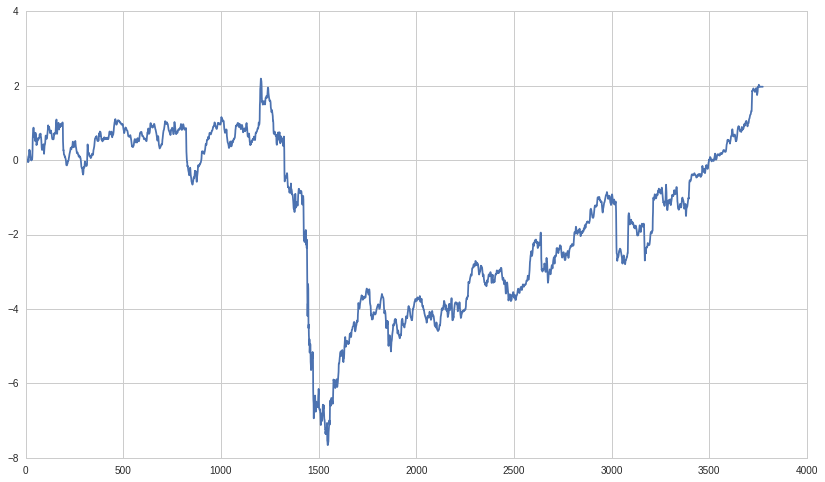

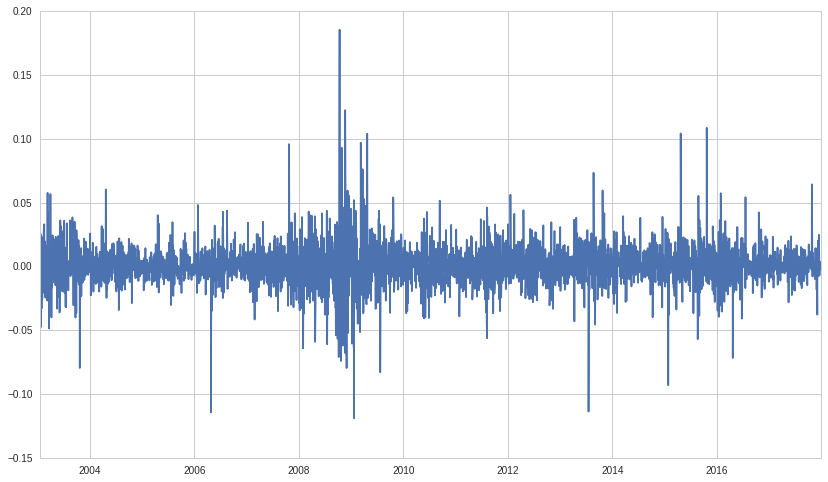

In [30]:
def get_returns(y_hat,y, data):
    returns = np.zeros(data.shape)
    for i in xrange(len(y_hat)):
        returns[i] = y_hat[i]*(np.sum(data[i+11:i+11+wait_days]))
    return returns

returns = get_returns(y1_hat, y1, data)
rets = returns#[returns !=0]
plt.plot(np.cumsum(rets))
plt.figure()
plt.plot(data[10:])


#STOPPED HERE>>> ERROR IN CODE? COMPILER? TURNING AN ARRAY INTO AN INT UNWANTED

In [31]:
len(y1_hat[y1_hat != -1])

3747

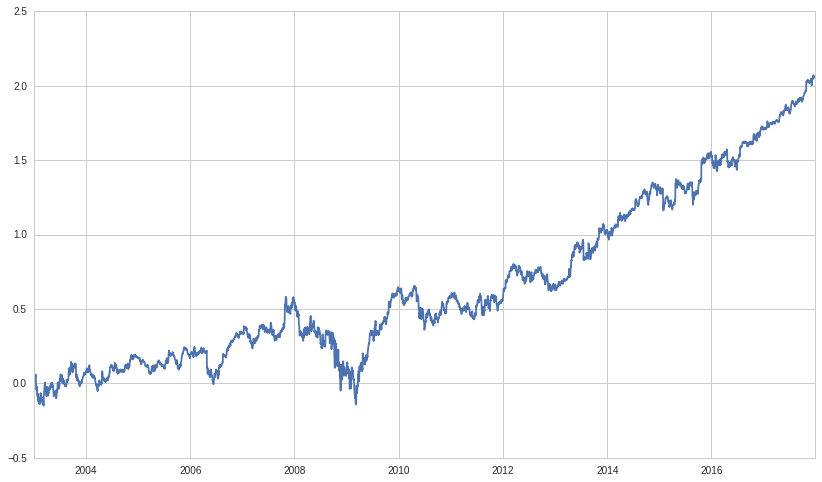

In [32]:
plt.plot(np.cumsum(data))

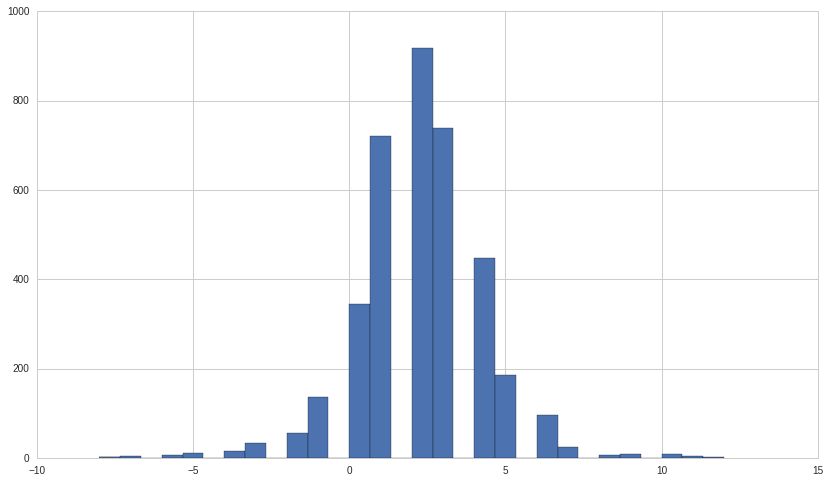

In [33]:
plt.hist(y1,bins =30);

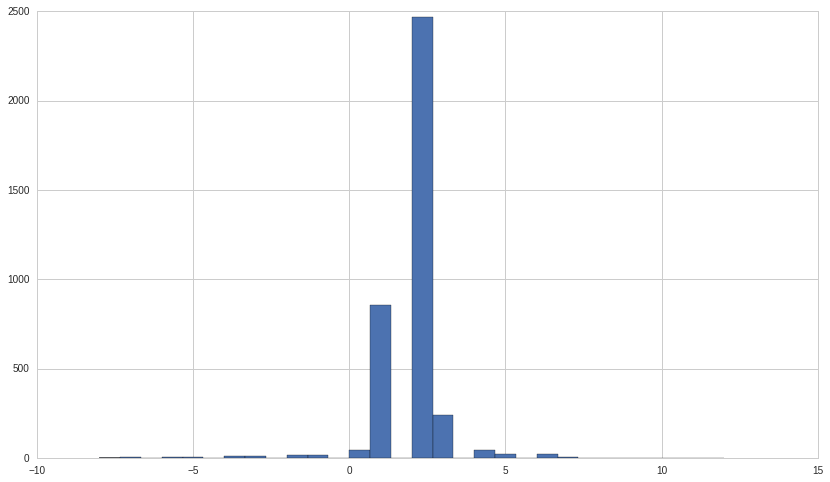

In [34]:
plt.hist(y1_hat, bins = 30);

In [35]:
data.head(20)/ data.std()

2003-01-03 00:00:00+00:00    0.058305
2003-01-06 00:00:00+00:00    1.134165
2003-01-07 00:00:00+00:00    1.133848
2003-01-08 00:00:00+00:00   -1.655166
2003-01-09 00:00:00+00:00    1.724631
2003-01-10 00:00:00+00:00    0.142007
2003-01-13 00:00:00+00:00    0.474464
2003-01-14 00:00:00+00:00    0.657211
2003-01-15 00:00:00+00:00   -0.747329
2003-01-16 00:00:00+00:00   -1.008676
2003-01-17 00:00:00+00:00   -4.338257
2003-01-21 00:00:00+00:00   -0.168339
2003-01-22 00:00:00+00:00   -0.348375
2003-01-23 00:00:00+00:00    1.571184
2003-01-24 00:00:00+00:00   -2.933896
2003-01-27 00:00:00+00:00   -0.809910
2003-01-28 00:00:00+00:00   -0.457194
2003-01-29 00:00:00+00:00    1.351633
2003-01-30 00:00:00+00:00   -2.024558
2003-01-31 00:00:00+00:00   -0.997019
Freq: C, Name: Equity(5061 [MSFT]), dtype: float64

In [36]:
context[0][10]

-4.0

array([-0.11894416, -0.08848885, -0.05803353, -0.02757822,  0.00287709,
        0.0333324 ,  0.06378772,  0.09424303,  0.12469834,  0.15515365,
        0.18560896])

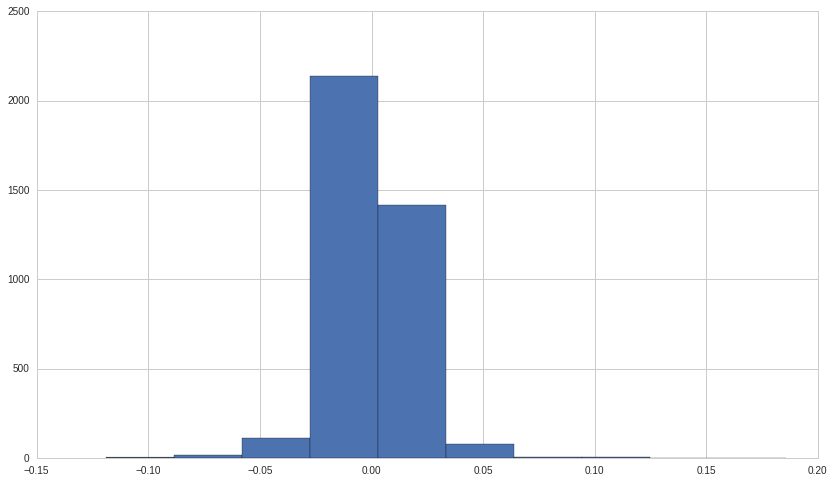

In [37]:
plt.hist(data, bins = 10)[1]# use this to reform disc_train - dicretise function

In [38]:
context

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
10,-4.0,-0.0,-0.0,2.0,-2.0,-0.0,-0.0,2.0,-2.0,-0.0,...,0.0,-1.0,-0.0,1.0,1.0,1.0,2.0,-1.0,2.0,2.0
11,-0.0,-0.0,2.0,-2.0,-0.0,-0.0,2.0,-2.0,-0.0,2.0,...,0.0,-4.0,-1.0,-0.0,1.0,1.0,1.0,2.0,-1.0,2.0
12,-0.0,2.0,-2.0,-0.0,-0.0,2.0,-2.0,-0.0,2.0,-1.0,...,0.0,-0.0,-4.0,-1.0,-0.0,1.0,1.0,1.0,2.0,-1.0
13,2.0,-2.0,-0.0,-0.0,2.0,-2.0,-0.0,2.0,-1.0,-0.0,...,0.0,-0.0,-0.0,-4.0,-1.0,-0.0,1.0,1.0,1.0,2.0
14,-2.0,-0.0,-0.0,2.0,-2.0,-0.0,2.0,-1.0,-0.0,1.0,...,0.0,2.0,-0.0,-0.0,-4.0,-1.0,-0.0,1.0,1.0,1.0
15,-0.0,-0.0,2.0,-2.0,-0.0,2.0,-1.0,-0.0,1.0,-1.0,...,0.0,-2.0,2.0,-0.0,-0.0,-4.0,-1.0,-0.0,1.0,1.0
16,-0.0,2.0,-2.0,-0.0,2.0,-1.0,-0.0,1.0,-1.0,2.0,...,0.0,-0.0,-2.0,2.0,-0.0,-0.0,-4.0,-1.0,-0.0,1.0
17,2.0,-2.0,-0.0,2.0,-1.0,-0.0,1.0,-1.0,2.0,-1.0,...,0.0,-0.0,-0.0,-2.0,2.0,-0.0,-0.0,-4.0,-1.0,-0.0
18,-2.0,-0.0,2.0,-1.0,-0.0,1.0,-1.0,2.0,-1.0,1.0,...,0.0,2.0,-0.0,-0.0,-2.0,2.0,-0.0,-0.0,-4.0,-1.0
19,-0.0,2.0,-1.0,-0.0,1.0,-1.0,2.0,-1.0,1.0,1.0,...,0.0,-2.0,2.0,-0.0,-0.0,-2.0,2.0,-0.0,-0.0,-4.0


In [39]:
data

2003-01-03 00:00:00+00:00    0.000946
2003-01-06 00:00:00+00:00    0.018411
2003-01-07 00:00:00+00:00    0.018406
2003-01-08 00:00:00+00:00   -0.026869
2003-01-09 00:00:00+00:00    0.027997
2003-01-10 00:00:00+00:00    0.002305
2003-01-13 00:00:00+00:00    0.007702
2003-01-14 00:00:00+00:00    0.010669
2003-01-15 00:00:00+00:00   -0.012132
2003-01-16 00:00:00+00:00   -0.016374
2003-01-17 00:00:00+00:00   -0.070425
2003-01-21 00:00:00+00:00   -0.002733
2003-01-22 00:00:00+00:00   -0.005655
2003-01-23 00:00:00+00:00    0.025506
2003-01-24 00:00:00+00:00   -0.047627
2003-01-27 00:00:00+00:00   -0.013148
2003-01-28 00:00:00+00:00   -0.007422
2003-01-29 00:00:00+00:00    0.021942
2003-01-30 00:00:00+00:00   -0.032866
2003-01-31 00:00:00+00:00   -0.016185
2003-02-03 00:00:00+00:00    0.023007
2003-02-04 00:00:00+00:00   -0.025385
2003-02-05 00:00:00+00:00   -0.007586
2003-02-06 00:00:00+00:00    0.009683
2003-02-07 00:00:00+00:00   -0.017413
2003-02-10 00:00:00+00:00    0.016759
2003-02-11 0